In [1]:
import os
import time
import copy
import glob 
import torch
import random
import numpy as np
import matplotlib
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image as im
from model import Gauss2D

In [2]:
show        = True 
pretrain    = False
data_dir    = 'data'
filename    = 'model_out_gauss.pth'
batch_size  = 20      #Number of samples in each batch
num_workers = 2
epoch_num   = 5      #Number of epochs to train the network
lr          = 0.1     # Learning rate

In [3]:
data_transforms = {
    'train': transforms.ToTensor(),
    'val': transforms.ToTensor()
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
               for x in ['train', 'val']}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cpu


In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Gauss2D.imshow(out,title=[class_names[x] for x in classes], fname='initial.jpg',show=True)


model_ft = models.resnet18(pretrained=pretrain)
if torch.cuda.device_count() > 1: 
    print("Using ", torch.cuda.device_count(),"gpus!")
    model_ft = nn.DataParallel(model_ft) #
    
model_ft=model_ft.to(device)

Epoch 0/4
----------
train Loss: 0.7919 Acc: 0.9053
val Loss: 0.1642 Acc: 0.9523

Epoch 1/4
----------
train Loss: 0.1891 Acc: 0.9378
val Loss: 0.1659 Acc: 0.9523

Epoch 2/4
----------
train Loss: 0.1524 Acc: 0.9486
val Loss: 0.1491 Acc: 0.9422

Epoch 3/4
----------
train Loss: 0.1458 Acc: 0.9533
val Loss: 0.0906 Acc: 0.9673

Epoch 4/4
----------
train Loss: 0.1294 Acc: 0.9600
val Loss: 0.0863 Acc: 0.9673

Training complete in 7m 11s
Best val Acc: 0.967337


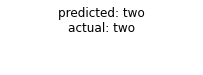

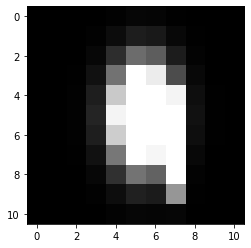

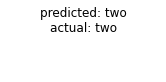

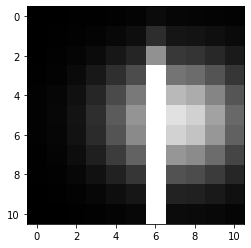

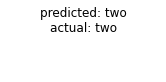

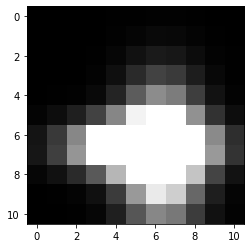

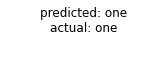

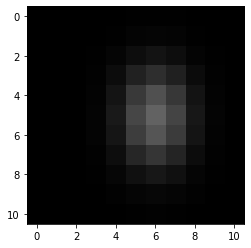

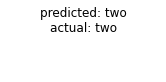

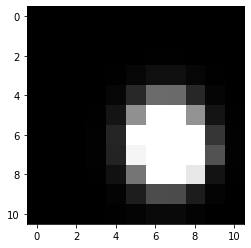

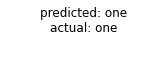

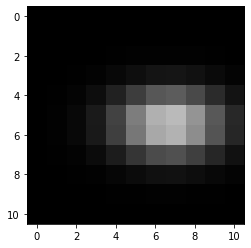

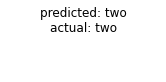

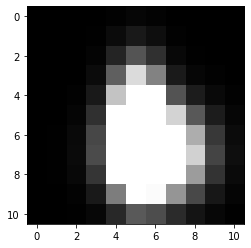

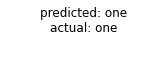

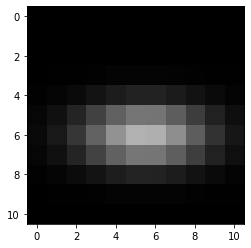

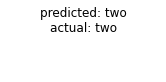

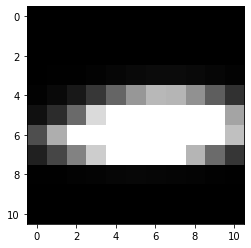

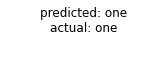

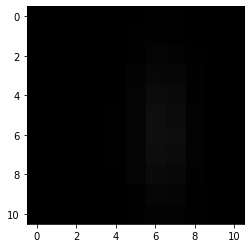

<Figure size 432x288 with 0 Axes>

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft = Gauss2D.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epoch_num, dataloaders=dataloaders, device=device,dataset_sizes=dataset_sizes)
torch.save(model_ft, filename)

Gauss2D.visualize_model(model_ft,num_images=10,device=device,dataloaders=dataloaders,class_names=class_names)